# Read Data

In [213]:
import numpy as np
import scanpy as sc

adata = sc.read_h5ad(
    "/home/jhaberbe/Projects/Personal/TokenGT/data/output-dgi-10-10-20MAY2025.h5ad"
)
adata = adata[adata.layers["transcript"].sum(axis=1) > 20].copy()
adata.obs["log_plin2_area"] = np.log1p(adata.obs["plin2_area"])
adata.obs["log_oil_red_o_area"] = np.log1p(adata.obs["oil_red_o_area"])
adata.obs["log_lipid_droplet_area"] = np.log1p(adata.obs["lipid_droplet_area"])

adata.X = adata.layers["transcript"].copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

/home/jhaberbe/Projects/Personal/TokenGT/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/jhaberbe/Projects/Personal/TokenGT/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
adata.X seems to be already log-transformed.


In [214]:
from scipy.spatial import cKDTree
adata.obs["z_centroid"] = adata.obs["folder"].replace({
    k: i * 10_000
    for i, k in enumerate(adata.obs["folder"].unique())
})

ckd_tree = cKDTree(adata.obs[["x_centroid", "y_centroid", "z_centroid"]])

_, neighbor_indicies = ckd_tree.query(adata.obs[["x_centroid", "y_centroid", "z_centroid"]], k = 31)
neighbor_indicies = neighbor_indicies.tolist()

/tmp/ipykernel_3674434/2419312085.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  adata.obs["z_centroid"] = adata.obs["folder"].replace({
/tmp/ipykernel_3674434/2419312085.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs["z_centroid"] = adata.obs["folder"].replace({


# Data Set 

In [222]:
import torch

class SpatialSingleCellDataSet:
    
    def __init__(
        self, 
        counts,
        log_normalized,
        plin2_area,
        oil_red_o_area,
        lipid_droplet_area,
        near_amyloid,
        neighbor_indices,
        specimen_ids
    ):
        # Gene Expression Information
        self.counts = self._to_tensor(counts, torch.float)
        self.log_normalized = self._to_tensor(log_normalized, torch.float)

        self.size_factors = (self.counts.sum(axis=1) / self.counts.sum(axis=1).mean()).log()

        # Pathology Information
        self.plin2_area = self._to_tensor(plin2_area, torch.float)
        self.oil_red_o_area = self._to_tensor(oil_red_o_area, torch.float)
        self.lipid_droplet_area = self._to_tensor(lipid_droplet_area, torch.float)
        self.near_amyloid = self._to_tensor(near_amyloid, torch.float)

        # Neighborhood Information
        self.specimen_ids = self._to_tensor(specimen_ids, torch.long)
        self.neighbor_indices = self._to_tensor(neighbor_indices, torch.long)

    @staticmethod
    def _to_tensor(x, dtype=torch.float):
        if isinstance(x, torch.Tensor):
            return x.detach().clone().to(dtype)
        else:
            return torch.tensor(x, dtype=dtype)

    def __len__(self):
        return self.counts.size(0)

    def __getitem__(self, idx):
        return {
            # Expression Information
            "counts": self.counts[idx],
            "log_normalized": self.log_normalized[idx],
            "size_factors": self.size_factors[idx],

            # Pathology Information
            "plin2_area": self.plin2_area[idx],
            "oil_red_o_area": self.oil_red_o_area[idx],
            "lipid_droplet_area": self.lipid_droplet_area[idx],
            "near_amyloid": self.near_amyloid[idx],

            # Neighborhood Information
            "neighbor_indices": self.neighbor_indices[idx],

            # Cell Metadata
            "specimen_ids": self.specimen_ids[idx],
        }

counts = torch.tensor(adata.layers["transcript"])
log_normalized = torch.tensor(adata.X)

plin2_area = torch.tensor(adata.obs["plin2_area"].values).log1p()
oil_red_o_area = torch.tensor(adata.obs["oil_red_o_area"].values).log1p()
lipid_droplet_area = torch.tensor(adata.obs["lipid_droplet_area"].values).log1p()
near_amyloid = torch.tensor(adata.obs["near_amyloid"].values).float()

neighbor_indices = torch.tensor(neighbor_indicies)
specimen_ids = torch.tensor(adata.obs["folder"].cat.codes.values)

dataset = SpatialSingleCellDataSet(
    counts,
    log_normalized,
    plin2_area,
    oil_red_o_area,
    lipid_droplet_area,
    near_amyloid,
    neighbor_indices,
    specimen_ids
)

input_data = dataset[0]

dataset[input_data["neighbor_indices"]]

{'counts': tensor([[0., 0., 1.,  ..., 1., 0., 0.],
         [0., 1., 1.,  ..., 4., 0., 0.],
         [0., 0., 0.,  ..., 2., 0., 0.],
         ...,
         [1., 0., 2.,  ..., 1., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'log_normalized': tensor([[0.0000, 0.0000, 1.0282,  ..., 1.0282, 0.0000, 0.0000],
         [0.0000, 0.5346, 0.5346,  ..., 1.3422, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 1.3048, 0.0000, 0.0000],
         ...,
         [0.2622, 0.0000, 0.4698,  ..., 0.2622, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.6243,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]),
 'size_factors': tensor([-0.7850,  0.1475, -0.4948,  0.5161, -0.2460, -0.5742, -0.0276, -0.7748,
          0.2358,  0.4046, -0.3593,  0.4678,  0.4412,  0.9418,  0.9048,  0.6938,
         -0.0767,  0.9490, -0.2342, -1.6564,  0.5217, -0.0518,  0.2358,  0.7123,
         -0.0667,  0.5807,  0.2577,  0.4077, 

In [223]:
import torch
from torch import nn
from torch.autograd import Function
import torch.nn.functional as F

# Gradient Reversal Layer implementation
class GradReverse(Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)  # Identity forward pass

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.lambda_, None

def grad_reverse(x, lambda_=1.0):
    return GradReverse.apply(x, lambda_)

# Variational Encoder (unchanged)
class VariationalEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )
        self.mu = nn.Linear(hidden_dim, embedding_dim)
        self.log_var = nn.Linear(hidden_dim, embedding_dim)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        h = self.shared(x)
        log_mu = self.mu(h)
        log_var = self.log_var(h)
        return log_mu, log_var

In [224]:

# Spatial Decoder (same as before, you can copy your existing decoder here)
class Decoder(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, n_genes, n_batches):
        super().__init__()
        self.batch_emb = nn.Embedding(n_batches, embedding_dim)
        self.shared = nn.Sequential(
            nn.Linear(embedding_dim * 2, hidden_dim),
            nn.ReLU()
        )
        self.nb_mu = nn.Linear(hidden_dim, n_genes)
        self.log_theta = nn.Parameter(torch.zeros(1))
        self.hurdle_logits = nn.ModuleDict({
            "plin2": nn.Linear(hidden_dim, 1),
            "oil_red_o": nn.Linear(hidden_dim, 1),
            "lipid_droplet": nn.Linear(hidden_dim, 1)
        })
        self.hurdle_mu = nn.ModuleDict({
            "plin2": nn.Linear(hidden_dim, 1),
            "oil_red_o": nn.Linear(hidden_dim, 1),
            "lipid_droplet": nn.Linear(hidden_dim, 1)
        })
        self.hurdle_log_var = nn.ModuleDict({
            "plin2": nn.Linear(hidden_dim, 1),
            "oil_red_o": nn.Linear(hidden_dim, 1),
            "lipid_droplet": nn.Linear(hidden_dim, 1)
        })
        self.near_amyloid_logit = nn.Linear(hidden_dim, 1)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, z, specimen_ids):
        batch_embedding = self.batch_emb(specimen_ids)
        h = self.shared(torch.cat([z, batch_embedding], dim=-1))
        log_mu_counts = self.nb_mu(h)
        log_theta = self.log_theta.expand_as(log_mu_counts)
        hurdle_out = {}
        for k in self.hurdle_logits.keys():
            hurdle_out[k] = {
                "logit_p": self.hurdle_logits[k](h),
                "mu": self.hurdle_mu[k](h),
                "log_var": self.hurdle_log_var[k](h)
            }
        near_amyloid_logit = self.near_amyloid_logit(h)
        return {
            "log_mu_counts": log_mu_counts,
            "log_theta": log_theta,
            "hurdle": hurdle_out,
            "near_amyloid_logit": near_amyloid_logit
        }

In [225]:
# Discriminator to predict specimen_ids from latent z
class Discriminator(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, n_batches):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_batches)
        )
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, z):
        return self.net(z)


In [226]:
# Full VAE with adversarial batch correction
class VAEWithAdversarial(nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_dim, n_genes, n_batches):
        super().__init__()
        self.encoder = VariationalEncoder(input_dim, hidden_dim, embedding_dim)
        self.decoder = Decoder(embedding_dim, hidden_dim, n_genes, n_batches)
        self.discriminator = Discriminator(embedding_dim, hidden_dim // 2, n_batches)

    def reparameterize(self, log_mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return log_mu + eps * std

    def forward(self, input_data):
        x = input_data["log_normalized"]
        specimen_ids = input_data["specimen_ids"]

        log_mu, log_var = self.encoder(x)
        z = self.reparameterize(log_mu, log_var)

        outputs = self.decoder(z, specimen_ids)
        outputs["size_factors"] = input_data["size_factors"]
        return outputs, log_mu, log_var, z

    def discriminate(self, z, lambda_grl=1.0):
        # Apply gradient reversal on z before discriminator
        z_rev = grad_reverse(z, lambda_grl)
        logits = self.discriminator(z_rev)
        return logits


In [227]:
import torch
import torch.nn.functional as F

# 1) Negative Binomial loss for counts

def negative_binomial_loss(x, log_mu, log_theta, size_factors):
    """
    x: observed counts (integer tensor)
    log_mu: decoded log mean (float tensor)
    log_theta: scalar or tensor, shared dispersion (log scale)
    size_factors: tensor, log scale size factors (same shape as batch size)
    """
    # Adjust log_mu by adding size factors (log scale)
    # size_factors shape: (batch_size,)
    # log_mu shape: (batch_size, n_genes)
    log_mu_adj = log_mu + size_factors.unsqueeze(-1)  # broadcast size_factors

    theta = torch.exp(log_theta)  # dispersion

    # logits for NB parameterization: logits = log_mu - log(mu + theta)
    logits = log_mu_adj - torch.log(torch.exp(log_mu_adj) + theta)

    nb_dist = torch.distributions.NegativeBinomial(total_count=theta, logits=logits)
    # Negative log likelihood (sum over genes and batch)
    neg_log_likelihood = -nb_dist.log_prob(x).mean()

    return neg_log_likelihood


# 2) Hurdle normal loss for each pathology feature

def hurdle_normal_loss(x, logit_p, mu, log_var):
    p = torch.sigmoid(logit_p)
    is_zero = (x == 0).float()

    bern_loss = -(is_zero * torch.log(1 - p + 1e-8) + (1 - is_zero) * torch.log(p + 1e-8))

    std = torch.exp(0.5 * log_var)
    const = torch.log(torch.tensor(2 * torch.pi, device=x.device, dtype=x.dtype))
    gaussian_nll = 0.5 * ( ((x - mu) / std) ** 2 + 2 * torch.log(std) + const )
    gaussian_nll = gaussian_nll * (1 - is_zero)

    total_loss = (bern_loss + gaussian_nll).mean()
    return total_loss


# 3) Logistic loss for near_amyloid (binary classification)

def near_amyloid_loss(logits, labels):
    """
    logits: raw logits output from decoder (before sigmoid)
    labels: binary labels (0/1 float tensor)
    """
    loss = F.binary_cross_entropy_with_logits(logits.squeeze(-1), labels, reduction='sum')
    return loss


# 4) KL divergence between latent posterior and prior

def kl_divergence(log_mu, log_var):
    """
    Standard VAE KL divergence
    """
    kl = -0.5 * torch.sum(1 + log_var - log_mu.pow(2) - log_var.exp())
    return kl

def discriminator_loss(discriminator_logits, specimen_ids):
    """
    Cross-entropy loss for discriminator predicting specimen_ids.
    """
    return F.cross_entropy(discriminator_logits, specimen_ids)

def compute_total_loss(
    outputs,
    input_data,
    log_mu,
    log_var,
    discriminator_logits=None,
    weight_kl=1.0,
    weight_nb=1.0,
    weight_hurdle=1.0,
    weight_amyloid=1.0,
    weight_adv=0.0,
):
    """
    Computes total loss for VAE model, optionally including adversarial loss.

    If `discriminator_logits` is provided, compute adversarial loss and include weighted in total loss.
    """

    # Negative Binomial loss (counts)
    nb_loss = negative_binomial_loss(
        x=input_data["counts"],
        log_mu=outputs["log_mu_counts"],
        log_theta=outputs["log_theta"],
        size_factors=input_data["size_factors"]
    )

    # Hurdle normal losses (sum over 3 features)
    hurdle_loss = 0.0
    for key in ["plin2", "oil_red_o", "lipid_droplet"]:
        h = outputs["hurdle"][key]
        x = input_data[f"{key}_area"]
        hurdle_loss += hurdle_normal_loss(x, h["logit_p"], h["mu"], h["log_var"])

    # Near amyloid logistic loss
    amyloid_loss = near_amyloid_loss(outputs["near_amyloid_logit"], input_data["near_amyloid"])

    # KL divergence
    kl_loss = kl_divergence(log_mu, log_var)

    # Adversarial loss (optional)
    if discriminator_logits is not None:
        adv_loss = discriminator_loss(discriminator_logits, input_data["specimen_ids"])
    else:
        adv_loss = torch.tensor(0.0, device=log_mu.device)

    # Total loss
    total_loss = (
        weight_nb * nb_loss
        + weight_hurdle * hurdle_loss
        + weight_amyloid * amyloid_loss
        + weight_kl * kl_loss
        + weight_adv * adv_loss
    )

    return total_loss, {
        "total_loss": total_loss.item(),
        "nb_loss": nb_loss.item(),
        "hurdle_loss": hurdle_loss.item(),
        "amyloid_loss": amyloid_loss.item(),
        "kl_loss": kl_loss.item(),
        "adv_loss": adv_loss.item() if isinstance(adv_loss, torch.Tensor) else adv_loss
    }


In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

batch_size = 2048
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: x)

vae = VAE(
    input_dim=366,
    hidden_dim=64,
    embedding_dim=8,
    n_genes=366,
    n_batches=12
).to(device)
vae.train()

discriminator = Discriminator(embedding_dim=8, hidden_dim=32, n_batches=12).to(device)
discriminator.train()

optimizer_vae = Adam(vae.parameters(), lr=1e-3)
optimizer_disc = Adam(discriminator.parameters(), lr=1e-3)

num_epochs = 10
adv_weight = 10.0
lambda_grl = 1.0

for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, batch_samples in enumerate(data_loader):
        # Convert list of dicts to dict of batched tensors and send to device
        batch_data = {key: torch.stack([sample[key] for sample in batch_samples]).to(device) for key in batch_samples[0].keys()}

        # --- Step 1: Train discriminator ---
        for i in range(20):
            optimizer_disc.zero_grad()
            with torch.no_grad():
                log_mu, log_var = vae.encoder(batch_data["log_normalized"])
                z = vae.reparameterize(log_mu, log_var)

            disc_logits = discriminator(z.detach())
            disc_loss = torch.nn.functional.cross_entropy(disc_logits, batch_data["specimen_ids"])
            disc_loss.backward()
            optimizer_disc.step()

        # --- Step 2: Train VAE ---
        optimizer_vae.zero_grad()

        log_mu, log_var = vae.encoder(batch_data["log_normalized"])
        z = vae.reparameterize(log_mu, log_var)

        outputs = vae.decoder(z, batch_data["specimen_ids"])
        outputs["size_factors"] = batch_data["size_factors"]

        z_rev = grad_reverse(z, lambda_grl)
        adv_logits = discriminator(z_rev)

        loss, loss_items = compute_total_loss(
            outputs=outputs,
            input_data=batch_data,
            log_mu=log_mu,
            log_var=log_var,
            discriminator_logits=adv_logits,
            weight_adv=adv_weight
        )

        loss.backward()
        optimizer_vae.step()

        running_loss += loss.item()

        if batch_idx % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}], Loss: {loss.item():.4f}, Disc Loss: {disc_loss.item():.4f}")

    epoch_loss = running_loss / len(data_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {epoch_loss:.4f}")

Using device: cuda
Epoch [1/10], Batch [0], Loss: 20919.9570, Disc Loss: 2.7749
Epoch [1/10], Batch [10], Loss: 6323.3306, Disc Loss: 2.5898
Epoch [1/10], Batch [20], Loss: 3792.9236, Disc Loss: 2.5515
Epoch [1/10], Batch [30], Loss: 2594.4475, Disc Loss: 2.5147
Epoch [1/10], Batch [40], Loss: 1976.0128, Disc Loss: 2.5025
Epoch [1/10], Batch [50], Loss: 1625.6956, Disc Loss: 2.4991
Epoch [1/10], Batch [60], Loss: 1373.7234, Disc Loss: 2.4903
Epoch [1/10], Batch [70], Loss: 1220.4363, Disc Loss: 2.4703
Epoch [1/10], Batch [80], Loss: 1057.1427, Disc Loss: 2.4771
Epoch [1/10], Batch [90], Loss: 1023.9200, Disc Loss: 2.4768
Epoch [1/10], Batch [100], Loss: 994.0304, Disc Loss: 2.4607
Epoch [1/10], Batch [110], Loss: 966.8807, Disc Loss: 2.4555
Epoch [1/10] Average Loss: 2649.5659
Epoch [2/10], Batch [0], Loss: 864.9129, Disc Loss: 2.4568
Epoch [2/10], Batch [10], Loss: 909.0124, Disc Loss: 2.4617
Epoch [2/10], Batch [20], Loss: 832.7845, Disc Loss: 2.4544
Epoch [2/10], Batch [30], Loss: 8

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x75857b01af90>>
Traceback (most recent call last):
  File "/home/jhaberbe/Projects/Personal/TokenGT/.venv/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


Epoch [2/10], Batch [70], Loss: 812.0033, Disc Loss: 2.4398
Epoch [2/10], Batch [80], Loss: 802.5653, Disc Loss: 2.4536
Epoch [2/10], Batch [90], Loss: 772.5071, Disc Loss: 2.4407
Epoch [2/10], Batch [100], Loss: 734.1063, Disc Loss: 2.4418
Epoch [2/10], Batch [110], Loss: 792.5178, Disc Loss: 2.4415
Epoch [2/10] Average Loss: 814.0111
Epoch [3/10], Batch [0], Loss: 798.1068, Disc Loss: 2.4443
Epoch [3/10], Batch [10], Loss: 771.9747, Disc Loss: 2.4433
Epoch [3/10], Batch [20], Loss: 788.1909, Disc Loss: 2.4445
Epoch [3/10], Batch [30], Loss: 724.0560, Disc Loss: 2.4387
Epoch [3/10], Batch [40], Loss: 792.1824, Disc Loss: 2.4366


In [134]:
import torch
from torch.utils.data import DataLoader

def extract_embeddings(model, dataset, batch_size=256, use_mean=True, device=None):
    """
    Extract latent embeddings for all samples in `dataset`.

    Args:
        model: trained VAE model with encoder
        dataset: dataset object (e.g. SpatialSingleCellDataSet)
        batch_size: batch size for DataLoader
        use_mean: if True, use encoder's mean (log_mu) as embedding,
                  else sample from latent distribution
        device: torch device (e.g. 'cuda' or 'cpu'), default auto-detect

    Returns:
        embeddings: Tensor of shape (n_samples, embedding_dim)
    """

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()
    model.to(device)

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: x)

    all_embeddings = []

    with torch.no_grad():
        for batch_samples in loader:
            batch_data = {key: torch.stack([sample[key] for sample in batch_samples]).to(device) for key in batch_samples[0].keys()}

            log_mu, log_var = model.encoder(batch_data["log_normalized"])

            if use_mean:
                embeddings = log_mu
            else:
                std = torch.exp(0.5 * log_var)
                eps = torch.randn_like(std)
                embeddings = log_mu + eps * std

            all_embeddings.append(embeddings.cpu())

    return torch.cat(all_embeddings, dim=0)

token_embeddings = extract_embeddings(vae, dataset)

# Embeddings

In [141]:
token_embeddings[::100].shape

torch.Size([5798, 16])

In [151]:
import torch
from torch.utils.data import Dataset

class SpatialEmbeddingDataset(Dataset):
    def __init__(self, embeddings, neighbor_indices):
        """
        Args:
            embeddings: Tensor of shape (n_cells, embedding_dim)
            neighbor_indices: LongTensor of shape (n_cells, n_neighbors)
        """
        self.embeddings = embeddings
        self.neighbor_indices = neighbor_indices

    def __len__(self):
        return self.embeddings.size(0)

    def __getitem__(self, idx):
        """
        Returns:
            {
                "center": embedding of center cell (embedding_dim,),
                "neighbors": embeddings of neighbors (n_neighbors, embedding_dim),
                "center_idx": index of the center cell
            }
        """
        center_embedding = self.embeddings[idx]
        neighbor_idxs = self.neighbor_indices[idx]
        neighbor_embeddings = self.embeddings[neighbor_idxs]

        return {
            "center": center_embedding,
            "neighbors": neighbor_embeddings,
            "center_idx": idx
        }

spatial_embedding_dataset = SpatialEmbeddingDataset(
    embeddings=token_embeddings,
    neighbor_indices=neighbor_indices[:, 1:]
)

In [163]:
from nflows.flows import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform

def build_simple_flow(embedding_dim, n_transforms=4, hidden_dim=64):
    base_dist = StandardNormal([embedding_dim])
    transforms = []
    for _ in range(n_transforms):
        transforms.append(
            MaskedAffineAutoregressiveTransform(
                features=embedding_dim,
                hidden_features=hidden_dim
            )
        )
    # Combine into a proper composite transform
    transform = CompositeTransform(transforms)
    return Flow(transform, base_dist)


In [164]:
class SpatialTransformerFlow(nn.Module):
    def __init__(self, embedding_dim, n_heads=4, n_layers=2, n_neighbors=30):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.n_neighbors = n_neighbors

        # Learnable CLS token
        self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_dim))

        # Positional encoding (simple learnable)
        self.positional_enc = nn.Parameter(torch.randn(1, n_neighbors + 2, embedding_dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim, nhead=n_heads, dim_feedforward=embedding_dim * 4, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Normalizing Flow for predicting next-token embedding
        self.flow = build_simple_flow(embedding_dim)

    def forward(self, center, neighbors):
        """
        center: (B, embedding_dim)
        neighbors: (B, n_neighbors, embedding_dim)
        """
        B = center.size(0)
        device = center.device

        # Start with [CLS] + center
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, D)
        current_seq = torch.cat([cls_tokens, center.unsqueeze(1)], dim=1)

        all_log_probs = []

        for step in range(neighbors.size(1)):
            seq = current_seq + self.positional_enc[:, :current_seq.size(1), :]

            h = self.transformer(seq)  # (B, seq_len, D)
            context = h[:, -1, :]  # last token representation

            # Predict probability of the next token using the flow
            next_token = neighbors[:, step, :]
            log_prob = self.flow.log_prob(next_token)  # unconditional for now
            all_log_probs.append(log_prob)

            # Append the ground truth neighbor to the sequence for next step
            current_seq = torch.cat([current_seq, next_token.unsqueeze(1)], dim=1)

        all_log_probs = torch.stack(all_log_probs, dim=1)  # (B, n_neighbors)
        return all_log_probs

def perplexity_loss(log_probs):
    """
    log_probs: (B, n_neighbors), log p(next_token)
    Returns: scalar loss (average perplexity)
    """
    nll = -log_probs  # negative log-likelihood per step
    entropy = nll.mean()  # average entropy across batch & steps
    perplexity = torch.exp(entropy)
    return perplexity

In [ ]:
import torch
from tqdm import tqdm
from collections import deque
import numpy as np
from torch.utils.data import DataLoader
from torch.optim import Adam

# --- Select device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Model & Optimizer ---
model = SpatialTransformerFlow(
    embedding_dim=token_embeddings.size(1),
    n_neighbors=30
).to(device)

optimizer = Adam(model.parameters(), lr=1e-4)

# --- DataLoader ---
loader = DataLoader(spatial_embedding_dataset, batch_size=2048, shuffle=True)

In [172]:
from torch.utils.tensorboard import SummaryWriter
import os

# Create a logs directory (TensorBoard will read from here)
log_dir = "runs/spatial_transformer_experiment"
writer = SummaryWriter(log_dir=log_dir)

In [182]:
import torch
import numpy as np

def perturb_neighbors_order_fast(neighbors, lam=4):
    """
    neighbors: tensor of shape (B, T) or (B, T, D)
    lam: mean number of swaps per batch element (Poisson)
    
    Returns neighbors with a few swaps applied on tokens [2,...] per batch element.
    """
    neighbors = neighbors.clone()
    shape = neighbors.shape
    batch_size = shape[0]
    n_tokens = shape[1]

    max_swaps = (n_tokens - 2) // 2
    if max_swaps <= 0:
        return neighbors

    # Sample swaps per batch element
    n_swaps_per_batch = np.random.poisson(lam, size=batch_size)
    n_swaps_per_batch = np.clip(n_swaps_per_batch, 0, max_swaps)

    # Allowed indices to swap: 2..n_tokens-1
    allowed_indices = torch.arange(2, n_tokens, device=neighbors.device)

    for i in range(batch_size):
        n_swaps = n_swaps_per_batch[i]
        if n_swaps == 0:
            continue

        # Sample 2 * n_swaps distinct indices without replacement
        # Because each swap swaps 2 tokens
        swap_indices = np.random.choice(allowed_indices.cpu().numpy(), size=2*n_swaps, replace=False)
        swap_indices = torch.tensor(swap_indices, device=neighbors.device)

        # Reshape to pairs
        swap_pairs = swap_indices.view(n_swaps, 2)

        # Swap all pairs at once
        if len(shape) == 3:
            # For embeddings
            neighbors_i = neighbors[i]
            temp = neighbors_i[swap_pairs[:,0]].clone()
            neighbors_i[swap_pairs[:,0]] = neighbors_i[swap_pairs[:,1]]
            neighbors_i[swap_pairs[:,1]] = temp
        else:
            # For indices
            neighbors_i = neighbors[i]
            temp = neighbors_i[swap_pairs[:,0]].clone()
            neighbors_i[swap_pairs[:,0]] = neighbors_i[swap_pairs[:,1]]
            neighbors_i[swap_pairs[:,1]] = temp

        neighbors[i] = neighbors_i

    return neighbors


In [183]:
from tqdm import tqdm
from collections import deque
import numpy as np

running_losses = deque(maxlen=100)
global_step = 0  # For TensorBoard x-axis

for epoch in range(1_000):
    model.train()
    total_loss = 0.0
    epoch_pbar = tqdm(loader, desc=f"Epoch {epoch+1}", leave=True)

    for batch in epoch_pbar:
        center = batch["center"].to(device, non_blocking=True)
        neighbors = batch["neighbors"].to(device, non_blocking=True)
        neighbors = perturb_neighbors_order(neighbors)

        optimizer.zero_grad()
        log_probs = model(center, neighbors)
        loss = perplexity_loss(log_probs)
        loss.backward()
        optimizer.step()

        # ---- Tracking ----
        loss_val = loss.item()
        total_loss += loss_val
        running_losses.append(loss_val)
        smooth_loss = np.mean(running_losses)
        global_step += 1

        # Update tqdm bar
        epoch_pbar.set_postfix({
            "batch_loss": f"{loss_val:.4f}",
            "smooth_loss(100)": f"{smooth_loss:.4f}"
        })

        # ---- TensorBoard Logging ----
        writer.add_scalar("Loss/Batch", loss_val, global_step)
        writer.add_scalar("Loss/Smooth_100", smooth_loss, global_step)

    avg_epoch_loss = total_loss / len(loader)
    writer.add_scalar("Loss/Epoch_Avg", avg_epoch_loss, epoch+1)
    print(f"Epoch {epoch+1}: Avg Perplexity = {avg_epoch_loss:.4f}")

writer.close()  # Close at the end of training


Epoch 1: 100%|██████████| 284/284 [01:05<00:00,  4.33it/s, batch_loss=481448384.0000, smooth_loss(100)=492535339.2000]


Epoch 1: Avg Perplexity = 516867100.6197


Epoch 2: 100%|██████████| 284/284 [01:04<00:00,  4.37it/s, batch_loss=413705056.0000, smooth_loss(100)=425506731.8400]


Epoch 2: Avg Perplexity = 446503799.4366


Epoch 3: 100%|██████████| 284/284 [01:05<00:00,  4.34it/s, batch_loss=358843424.0000, smooth_loss(100)=367999331.5200]


Epoch 3: Avg Perplexity = 386033579.8310


Epoch 4: 100%|██████████| 284/284 [01:05<00:00,  4.34it/s, batch_loss=309650528.0000, smooth_loss(100)=318433857.2800]


Epoch 4: Avg Perplexity = 333980387.1549


Epoch 5: 100%|██████████| 284/284 [01:05<00:00,  4.34it/s, batch_loss=271389984.0000, smooth_loss(100)=275776896.9600]


Epoch 5: Avg Perplexity = 289144103.3239


Epoch 6: 100%|██████████| 284/284 [01:05<00:00,  4.36it/s, batch_loss=233578704.0000, smooth_loss(100)=238902505.9200]


Epoch 6: Avg Perplexity = 250455629.7465


Epoch 7: 100%|██████████| 284/284 [01:05<00:00,  4.31it/s, batch_loss=201372400.0000, smooth_loss(100)=207093808.1600]


Epoch 7: Avg Perplexity = 217059474.5352


Epoch 8: 100%|██████████| 284/284 [01:04<00:00,  4.39it/s, batch_loss=175761440.0000, smooth_loss(100)=179620639.5200]


Epoch 8: Avg Perplexity = 188211573.2394


Epoch 9: 100%|██████████| 284/284 [01:04<00:00,  4.41it/s, batch_loss=152242368.0000, smooth_loss(100)=155808183.6800]


Epoch 9: Avg Perplexity = 163264642.7042


Epoch 10: 100%|██████████| 284/284 [01:03<00:00,  4.44it/s, batch_loss=130652432.0000, smooth_loss(100)=134882630.8800]


Epoch 10: Avg Perplexity = 141556492.7324


Epoch 11: 100%|██████████| 284/284 [01:03<00:00,  4.48it/s, batch_loss=102027992.0000, smooth_loss(100)=106291645.4400]


Epoch 11: Avg Perplexity = 115521978.7042


Epoch 12: 100%|██████████| 284/284 [01:03<00:00,  4.44it/s, batch_loss=79747504.0000, smooth_loss(100)=83710411.3600] 


Epoch 12: Avg Perplexity = 90508778.0000


Epoch 13: 100%|██████████| 284/284 [01:04<00:00,  4.37it/s, batch_loss=64721088.0000, smooth_loss(100)=67097171.5200]


Epoch 13: Avg Perplexity = 72116971.7465


Epoch 14: 100%|██████████| 284/284 [01:04<00:00,  4.39it/s, batch_loss=52220748.0000, smooth_loss(100)=54559845.4400]


Epoch 14: Avg Perplexity = 58368836.0423


Epoch 15: 100%|██████████| 284/284 [01:04<00:00,  4.41it/s, batch_loss=43114772.0000, smooth_loss(100)=44892895.4000]


Epoch 15: Avg Perplexity = 47847857.5070


Epoch 16: 100%|██████████| 284/284 [01:05<00:00,  4.36it/s, batch_loss=36021544.0000, smooth_loss(100)=37286003.4800]


Epoch 16: Avg Perplexity = 39626262.9296


Epoch 17: 100%|██████████| 284/284 [01:05<00:00,  4.31it/s, batch_loss=30363222.0000, smooth_loss(100)=31223131.1000]


Epoch 17: Avg Perplexity = 33091320.3169


Epoch 18: 100%|██████████| 284/284 [01:05<00:00,  4.31it/s, batch_loss=25501672.0000, smooth_loss(100)=26303254.1000]


Epoch 18: Avg Perplexity = 27821718.8451


Epoch 19: 100%|██████████| 284/284 [01:05<00:00,  4.31it/s, batch_loss=21533336.0000, smooth_loss(100)=22280073.5800]


Epoch 19: Avg Perplexity = 23523404.0211


Epoch 20: 100%|██████████| 284/284 [01:05<00:00,  4.32it/s, batch_loss=15640621.0000, smooth_loss(100)=16751678.0200]


Epoch 20: Avg Perplexity = 18827760.4859


Epoch 21: 100%|██████████| 284/284 [01:05<00:00,  4.34it/s, batch_loss=11117887.0000, smooth_loss(100)=11850209.7100]


Epoch 21: Avg Perplexity = 13264696.4401


Epoch 22: 100%|██████████| 284/284 [01:06<00:00,  4.27it/s, batch_loss=8230858.0000, smooth_loss(100)=8714181.0250]  


Epoch 22: Avg Perplexity = 9644257.1637


Epoch 23: 100%|██████████| 284/284 [01:05<00:00,  4.32it/s, batch_loss=6249822.5000, smooth_loss(100)=6597051.1050]


Epoch 23: Avg Perplexity = 7225099.8644


Epoch 24: 100%|██████████| 284/284 [01:04<00:00,  4.37it/s, batch_loss=4994873.0000, smooth_loss(100)=5135648.6200]


Epoch 24: Avg Perplexity = 5572217.6320


Epoch 25:  59%|█████▉    | 168/284 [00:39<00:27,  4.29it/s, batch_loss=4295465.0000, smooth_loss(100)=4469281.4950]


KeyboardInterrupt: 

In [185]:

@torch.no_grad()
def extract_cls_latents(model, loader, device="cuda"):
    """
    Extracts CLS token latents for full sequences (no stepwise addition).

    Args:
        model: trained SpatialTransformerFlow
        loader: DataLoader yielding {"center", "neighbors"}
        device: device to run extraction on

    Returns:
        latents: torch.Tensor, shape (N, embedding_dim)
    """
    model.eval()
    model.to(device)
    all_latents = []

    for batch in loader:
        center = batch["center"].to(device)
        neighbors = batch["neighbors"].to(device)  # (B, n_neighbors, D)
        B = center.size(0)

        # Full token sequence: [CLS] + center + neighbors
        cls_tokens = model.cls_token.expand(B, -1, -1)
        full_seq = torch.cat([cls_tokens, center.unsqueeze(1), neighbors], dim=1)

        # Add positional encoding and run transformer once
        seq = full_seq + model.positional_enc[:, :full_seq.size(1), :]
        h = model.transformer(seq)  # (B, seq_len, D)

        # CLS latent = first token's representation
        cls_latent = h[:, 0, :]
        all_latents.append(cls_latent.cpu())

    return torch.cat(all_latents, dim=0)

cls_latents = extract_cls_latents(model, loader, device=device)
print(cls_latents.shape)  # (N, embedding_dim)


torch.Size([579713, 16])


In [188]:
adata.obsm["latent_representation"] = cls_latents.detach().cpu().numpy()

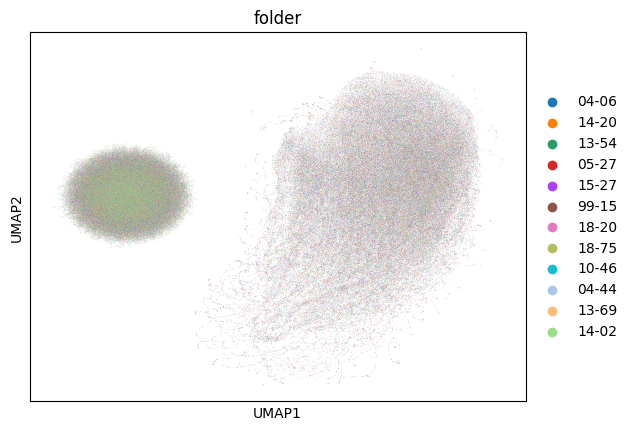

In [ ]:
# sc.pp.neighbors(adata, use_rep="latent_representation")
# sc.tl.umap(adata)
sc.pl.umap(adata, color="folder")


In [196]:
sc.tl.leiden(adata, resolution=0.1, flavor="igraph", n_iterations=2)

<Axes: >

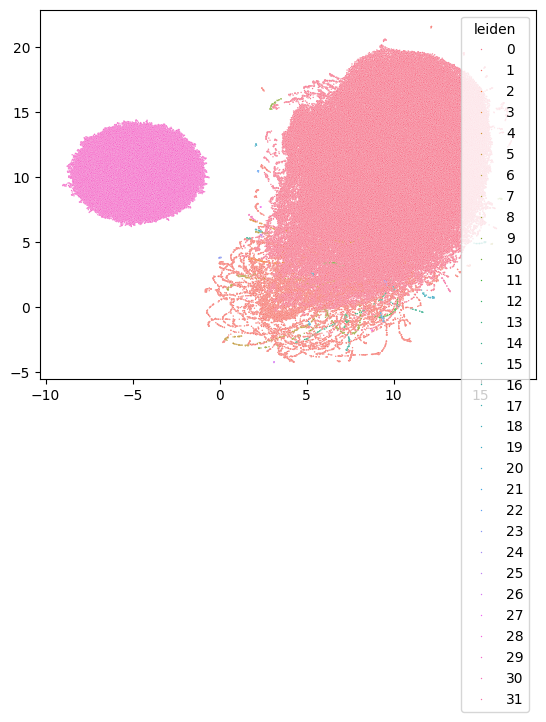

In [201]:
import seaborn as sns
sns.scatterplot(
    x=adata.obsm["X_umap"][:, 0],
    y=adata.obsm["X_umap"][:, 1],
    hue=adata.obs["leiden"], 
    s=1
)

<Axes: xlabel='x_centroid', ylabel='y_centroid'>

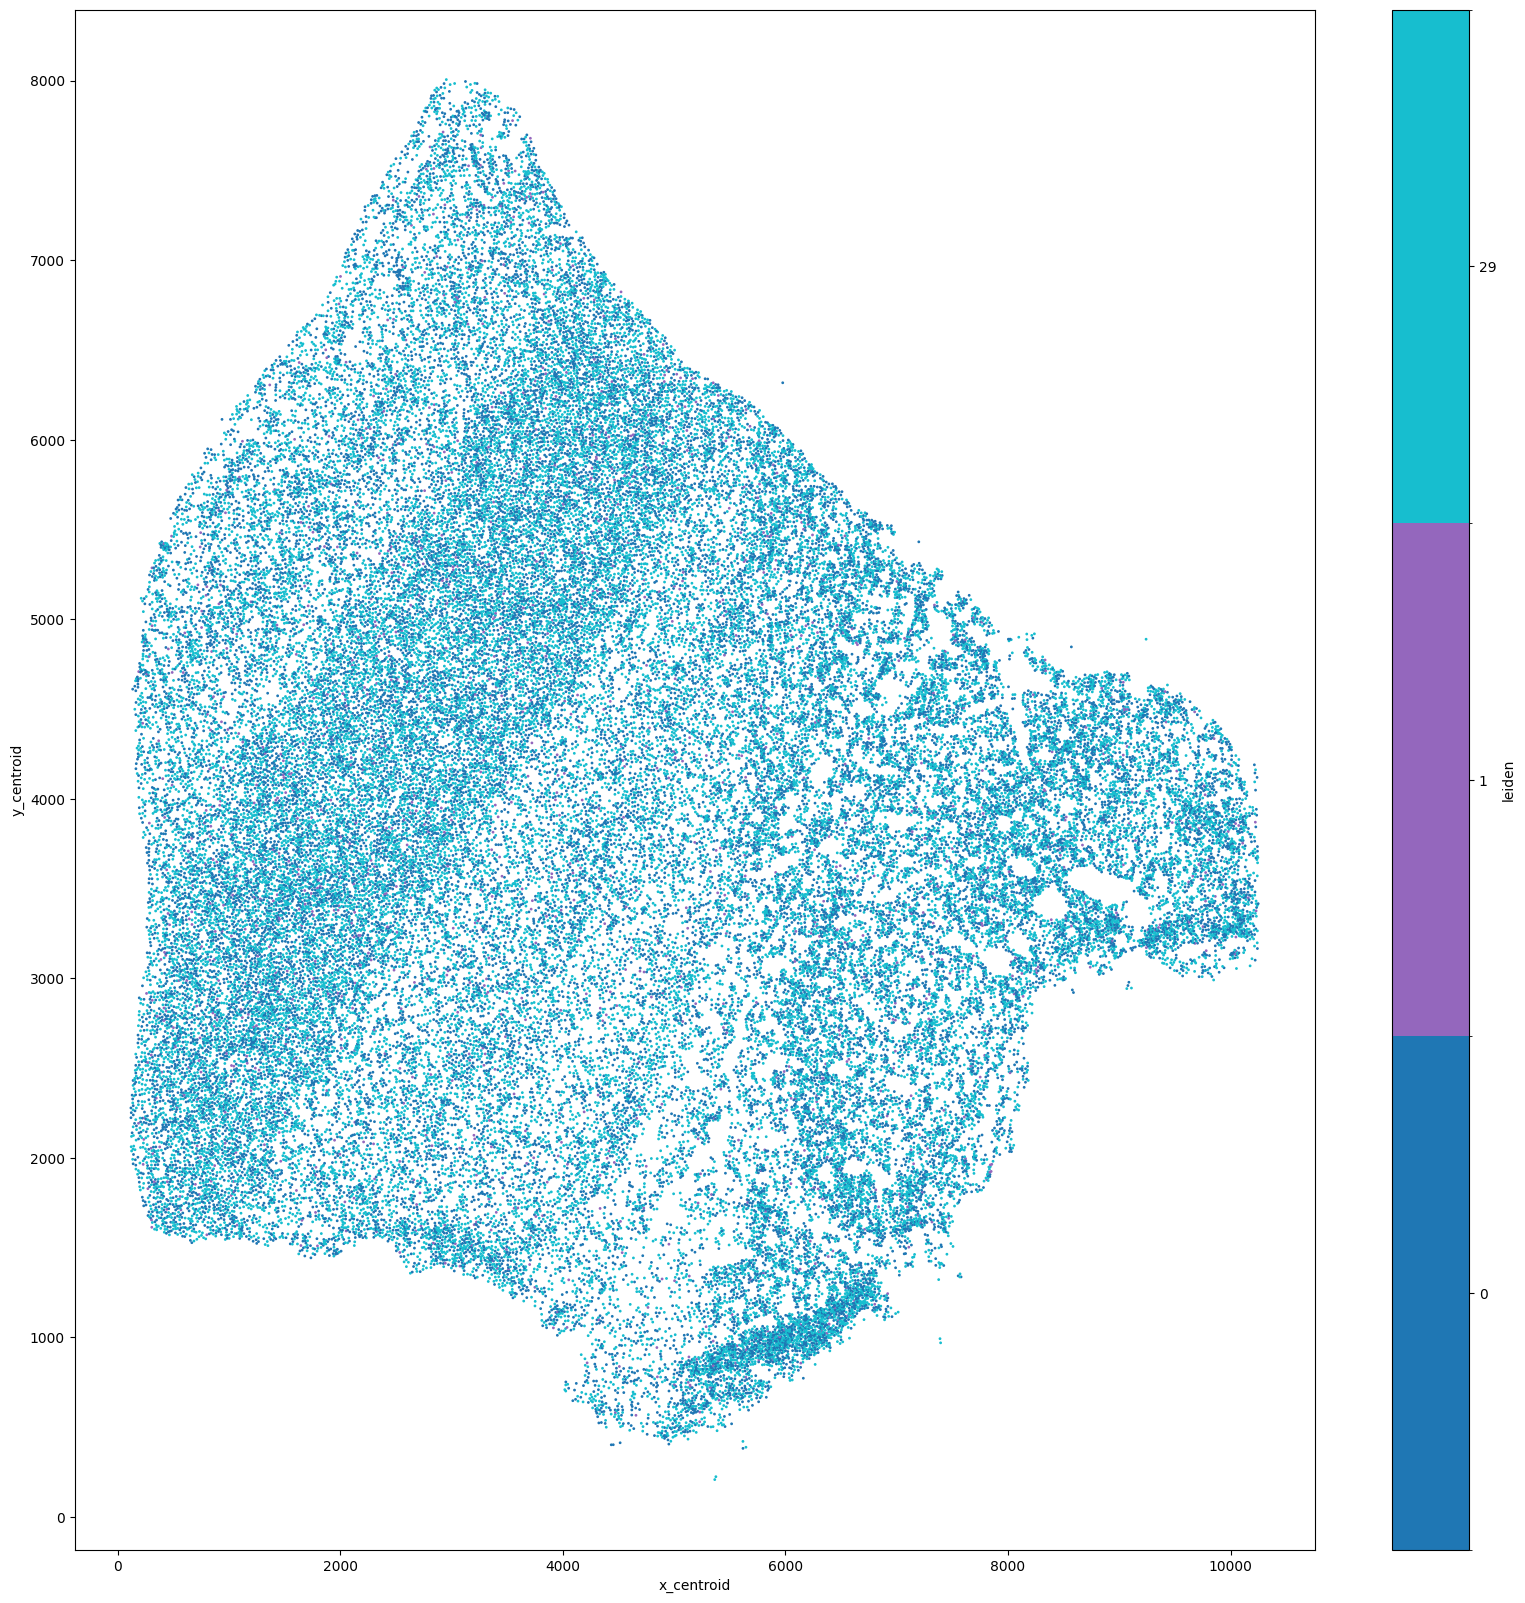

In [211]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(20, 20))
adata[adata.obs["leiden"].isin(["0", "1", "29"]) & adata.obs["folder"].eq("05-27")].obs.plot.scatter(
    x="x_centroid",
    y="y_centroid",
    c="leiden",
    s=1,
    cmap="tab10",
    ax=ax
)